In [1]:
import numpy as np
import codecs
import pickle
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Lambda, Flatten, Input, MaxPooling2D, Convolution2D,Conv2D,Activation,BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from scipy import misc
import os
from os.path import isfile, join
import itertools
import random
import keras
from keras.constraints import maxnorm
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import SGD,Adam
from keras.applications import VGG16
from keras.layers.merge import concatenate
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Image
import PIL
import glob
from scipy.misc import imresize, imread
from scipy.spatial.distance import pdist, squareform, cdist
import cv2

Using TensorFlow backend.


In [2]:
np.random.seed(7)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
TRAIN_DIR='data/balanced_train'
TEST_DIR='data/TEST'

In [3]:
'''
Created on Jul 10, 2016

@author: ssudholt
'''
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist

def map_from_feature_matrix(features, labels, metric, drop_first):
    '''
    Computes mAP and APs from a given matrix of feature vectors
    Each sample is used as a query once and all the other samples are
    used for testing. The user can specify whether he wants to include
    the query in the test results as well or not.
    
    Args:
        features (2d-ndarray): the feature representation from which to compute the mAP
        labels (1d-ndarray or list): the labels corresponding to the features (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # argument error checks
    if features.shape[0] != len(labels):
        raise ValueError('The number of feature vectors and number of labels must match')
    # compute the pairwise distances from the
    # features
    dists = pdist(X=features, metric=metric)
    dists = squareform(dists)
    inds = np.argsort(dists, axis=1)
    retr_mat = np.tile(labels, (features.shape[0],1))
    
    # compute two matrices for selecting rows and columns
    # from the label matrix
    # -> advanced indexing
    row_selector = np.transpose(np.tile(np.arange(features.shape[0]), (features.shape[0],1)))
    retr_mat = retr_mat[row_selector, inds]
    
    # create the relevance matrix
    rel_matrix = retr_mat == np.atleast_2d(labels).T
    if drop_first:
        rel_matrix = rel_matrix[:,1:]
        
    # calculate mAP and APs
    map_calc = MeanAveragePrecision()
    avg_precs = np.array([map_calc.average_precision(row) for row in rel_matrix])
    mAP = np.mean(avg_precs)
    return mAP, avg_precs

def map_from_query_test_feature_matrices(query_features, test_features, query_labels, test_labels, 
                                         metric, drop_first=False):
    '''
    Computes mAP and APs for a given matrix of query representations
    and another matrix of test representations
    Each query is used once to rank the test samples.
    
    Args:
        query_features (2d-ndarray): the feature representation for the queries
        query_labels (1d-ndarray or list): the labels corresponding to the queries (either numeric or characters)
        test_features (2d-ndarray): the feature representation for the test samples
        test_labels (1d-ndarray or list): the labels corresponding to the test samples (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # some argument error checking
    if query_features.shape[1] != test_features.shape[1]:
        raise ValueError('Shape mismatch')
    if query_features.shape[0] != len(query_labels):
        raise ValueError('The number of query feature vectors and query labels does not match')
    if test_features.shape[0] != len(test_labels):
        raise ValueError('The number of test feature vectors and test labels does not match')
    
    # compute the nearest neighbors
    dist_mat = cdist(XA=query_features, XB=test_features, metric=metric)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    
    # create the retrieval matrix
    retr_mat = np.tile(test_labels, (len(query_labels),1))
    row_selector = np.transpose(np.tile(np.arange(len(query_labels)), (len(test_labels),1)))
    retr_mat = retr_mat[row_selector, retrieval_indices]
    
    # create the relevance matrix
    relevance_matrix = retr_mat == np.atleast_2d(query_labels).T
    if drop_first:
        relevance_matrix = relevance_matrix[:,1:]
    
    # calculate mAP and APs
    mapCalc = MeanAveragePrecision()
    avg_precs = np.array([mapCalc.average_precision(row) for row in relevance_matrix], ndmin=2).flatten()
    mAP = np.mean(avg_precs)    
    return mAP, avg_precs

class IterativeMean(object):
    '''
    Class for iteratively computing a mean. With every new value (@see: _add_value)
    the mean will be updated 
    '''
    
    def __init__(self, mean_init=0.0):
        self.__mean = mean_init
        self.__N = 0.0
        
    def add_value(self, value):
        '''
        Updates the mean with respect to value
        
        Args:
            value (float): The value that will be incorporated in the mean
        '''  
        self.__mean = (self.__N / (self.__N + 1)) * self.__mean + (1.0 / (self.__N + 1)) * value
        self.__N += 1
        
    def get_mean(self):
        return self.__mean
    
    def reset(self):
        self.__mean = 0.0
        self.__N = 0.0
         

class MeanAveragePrecision(IterativeMean):
    '''
    Computes average precision values and iteratively updates their mean
    '''
    def __init__(self):
        super(MeanAveragePrecision, self).__init__()        
        
    def average_precision(self, ret_vec_relevance, gt_relevance_num=None):
        '''
        Computes the average precision and updates the mean average precision
        
        Args:
            ret_vec_relevance (1d-ndarray): array containing ground truth (gt) relevance values
            gt_relevance_num (int): The number of relevant samples in retrieval. If None the sum
                                    over the retrieval gt list is used.
        '''
        ret_vec_cumsum = np.cumsum(ret_vec_relevance, dtype=float)
        ret_vec_range = np.arange(1, ret_vec_relevance.size + 1)
        ret_vec_precision = ret_vec_cumsum / ret_vec_range
        
        if gt_relevance_num is None:
            n_relevance = ret_vec_relevance.sum()
        else:
            n_relevance = gt_relevance_num

        if n_relevance > 0:
            ret_vec_ap = (ret_vec_precision * ret_vec_relevance).sum() / n_relevance
        else:
            ret_vec_ap = 0.0
        
        super(MeanAveragePrecision, self).add_value(ret_vec_ap)
        
        return ret_vec_ap

In [4]:
def n_image_pair_names_from_folder(foldername,shuffle,ratio,number_of_same_pairs):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        list_same_pairs=list(same_pairs_it)
        random.shuffle(list_same_pairs)
        n_same_pairs=list_same_pairs[:number_of_same_pairs]
        # for each same pair, a different pair
        for ref_image, same_image in n_same_pairs:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                while True:
                    j = np.random.randint(low=0, high=len(class_list), size=1)[0]
                    if j != i: break
                dif_image_candidates = image_classes[class_list[j]]
                k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
                dif_image = dif_image_candidates[k]
                image_pairs.append((ref_image, dif_image, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

In [5]:
def image_pair_names_from_folder(foldername,shuffle,ratio):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        # for each same pair, a different pair
        for ref_image, same_image in same_pairs_it:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                while True:
                    j = np.random.randint(low=0, high=len(class_list), size=1)[0]
                    if j != i: break
                dif_image_candidates = image_classes[class_list[j]]
                k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
                dif_image = dif_image_candidates[k]
                image_pairs.append((ref_image, dif_image, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

In [6]:
train_pair_names=n_image_pair_names_from_folder(TRAIN_DIR,True,1,100)
number_of_train_pairs=len(train_pair_names)
print("Some sample train pair names: ", train_pair_names[:5])
print('number of train pairs: ', number_of_train_pairs)

Some sample train pair names:  [('2991_1a12.png', '2991_1a27.png', 1), ('1207_1a14.png', '1207_1a6.png', 1), ('610_1a3.png', '610_1a12.png', 1), ('73_2a24.png', '2551_1a9.png', 0), ('1289_1.png', '2636_1a27.png', 0)]
number of train pairs:  623400


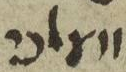

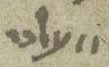

In [7]:
pair1 = Image(TRAIN_DIR+'/252_2.png')
pair2 = Image(TRAIN_DIR+'/252_1.png')
display(pair1,pair2)

In [8]:
def get_input(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (90, 40))
    img = img.astype('float32')
    img = img / 255. 
    img = img.reshape(img.shape + (1,))
    return (img)

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return [X[:, 0], X[:, 1]], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim,)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            image1=get_input(TRAIN_DIR+'/'+ID[0])
            image2=get_input(TRAIN_DIR+'/'+ID[1])
            X += [[image1, image2]]

            # Store class
            y.append(ID[2])
            aX=np.array(X)
            ay=np.array(y)

        return aX,ay


In [10]:
def load_test_data(foldername):
    images=[]
    labels=[]
    for image_name in os.listdir(foldername):
        label = int(image_name[0:-4].split('_')[0])
        labels.append(label)
        image=get_input(foldername+'/'+image_name)
        images.append(image)
    return np.array(images), np.array(labels)

In [11]:
def show_array(a):
    plt.imshow(a, cmap=plt.get_cmap('gray'))
    plt.show()

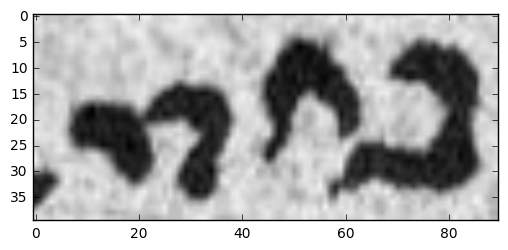

In [12]:
x_test, y_test=load_test_data(TEST_DIR)
show_array(np.squeeze(x_test[0]))

In [13]:
def create_base_network(input_dim):
    model=Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_dim, activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))


    return model

In [14]:
class custom_call(Callback):
    def __init__(self):
        self.patient=0
        self.best_map=0
    def on_epoch_end(self, epoch, logs={}):
        if self.patient>=15:
            print('patient= ', self.patient)
            self.model.stop_training = True
        feat_extractor = Model(inputs=self.model.layers[2].get_input_at(0), outputs=self.model.layers[2].layers[19].output)
        features=feat_extractor.predict(x_test)
        current_map=map_from_feature_matrix(features, y_test, 'cosine', True)[0]
        print(' map:',current_map)
        if current_map>=self.best_map:
            self.patient=0
            self.best_map=current_map
            print('best map=',self.best_map)
            print('patient=',self.patient)
            for f in glob.glob("random_pairs_best_model*"):
                os.remove(f)
            self.model.save('random_pairs_best_model_'+str(self.best_map)[:5])
        else:
            self.patient=self.patient+1
            print('current map=',current_map)
            print('best map=',self.best_map)
            print('patient=',self.patient)
    def on_batch_end(self,batch,logs={}):
        if batch%500==0:
            feat_extractor = Model(inputs=self.model.layers[2].get_input_at(0), outputs=self.model.layers[2].layers[19].output)
            features=feat_extractor.predict(x_test)
            test_map=map_from_feature_matrix(features, y_test, 'cosine', True)[0]
            print('test map:',test_map)
            

In [15]:
print_map=custom_call()
training_generator = DataGenerator(train_pair_names, batch_size=16, shuffle=True)

In [16]:
def abs_diff_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1


def get_abs_diff(vects):
    x, y = vects
    return K.abs(x - y)

#model=load_model('random_pairs_best_model_0.363')

input_dim = (40,90,1)
base_network = create_base_network(input_dim)
input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

abs_diff = Lambda(get_abs_diff, output_shape=abs_diff_output_shape)([processed_a, processed_b])
flattened_weighted_distance = Dense(1, activation='sigmoid')(abs_diff)
model = Model(inputs=[input_a, input_b], outputs=flattened_weighted_distance)


In [17]:
opt = SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
feat_extractor = Model(inputs=model.layers[2].get_input_at(0), outputs=model.layers[2].layers[19].output)
features=feat_extractor.predict(x_test)

In [19]:
map_from_feature_matrix(features, y_test, 'cosine', True)[0]

0.26618146066439613

In [20]:
model.fit_generator(training_generator,
                    epochs=100,
                    callbacks=[print_map])

Epoch 1/100
test map: 0.243447619812
    3/38962 [..............................] - ETA: 25:47:23 - loss: 2.1245 - acc: 0.4167

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.479335). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.740166). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.2513 - acc: 0.8989 map: 0.393415239828
best map= 0.393415239828
patient= 0
38962/38962 [==============================] - 4396s 113ms/step - loss: 0.2513 - acc: 0.8989
Epoch 2/100
test map: 0.392557503895
    3/38962 [..............................] - ETA: 20:49:08 - loss: 0.0532 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.477412). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.739222). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9537 map: 0.498805413411
best map= 0.498805413411
patient= 0
38962/38962 [==============================] - 4396s 113ms/step - loss: 0.1206 - acc: 0.9537
Epoch 3/100
test map: 0.498752603799
    3/38962 [..............................] - ETA: 21:07:26 - loss: 0.1341 - acc: 0.9375

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.553881). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.777429). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0715 - acc: 0.9735 map: 0.532979717877
best map= 0.532979717877
patient= 0
38962/38962 [==============================] - 4384s 113ms/step - loss: 0.0715 - acc: 0.9735
Epoch 4/100
test map: 0.533346099922
    3/38962 [..............................] - ETA: 20:56:21 - loss: 0.0269 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.510910). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.756095). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9829 map: 0.55237900863
best map= 0.55237900863
patient= 0
38962/38962 [==============================] - 4398s 113ms/step - loss: 0.0472 - acc: 0.9829
Epoch 5/100
test map: 0.552376516562
    2/38962 [..............................] - ETA: 32:05:16 - loss: 0.0212 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.725121). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.863040). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9882 map: 0.556440325648
best map= 0.556440325648
patient= 0
38962/38962 [==============================] - 4392s 113ms/step - loss: 0.0330 - acc: 0.9882
Epoch 6/100
test map: 0.556409928065
    3/38962 [..............................] - ETA: 20:43:10 - loss: 0.0016 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.448741). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.724876). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9916 map: 0.571046468833
best map= 0.571046468833
patient= 0
38962/38962 [==============================] - 4367s 112ms/step - loss: 0.0239 - acc: 0.9916
Epoch 7/100
test map: 0.571085103981
    3/38962 [..............................] - ETA: 21:08:31 - loss: 0.0010 - acc: 1.0000    

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.564955). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.783135). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9935 map: 0.56917721974
current map= 0.56917721974
best map= 0.571046468833
patient= 1
38962/38962 [==============================] - 4371s 112ms/step - loss: 0.0182 - acc: 0.9935
Epoch 8/100
test map: 0.56912901619
    3/38962 [..............................] - ETA: 21:34:33 - loss: 0.0021 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.680578). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.840900). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9952 map: 0.576576040503
best map= 0.576576040503
patient= 0
38962/38962 [==============================] - 4370s 112ms/step - loss: 0.0135 - acc: 0.9952
Epoch 9/100
test map: 0.575849480208
    3/38962 [..............................] - ETA: 21:33:15 - loss: 0.1079 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.674592). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.837847). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9960 map: 0.571377592624
current map= 0.571377592624
best map= 0.576576040503
patient= 1
38962/38962 [==============================] - 4376s 112ms/step - loss: 0.0112 - acc: 0.9960
Epoch 10/100
test map: 0.571398727447
    3/38962 [..............................] - ETA: 21:05:24 - loss: 0.0021 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.552987). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.776996). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9967 map: 0.576282666748
current map= 0.576282666748
best map= 0.576576040503
patient= 2
38962/38962 [==============================] - 4382s 112ms/step - loss: 0.0092 - acc: 0.9967
Epoch 11/100
test map: 0.576272500628
    3/38962 [..............................] - ETA: 21:33:26 - loss: 6.6448e-04 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.672593). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.836944). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9972 map: 0.576812177136
best map= 0.576812177136
patient= 0
38962/38962 [==============================] - 4381s 112ms/step - loss: 0.0081 - acc: 0.9972
Epoch 12/100
test map: 0.57710708354
    3/38962 [..............................] - ETA: 20:55:34 - loss: 0.0268 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.505693). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.753387). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9976 map: 0.580549716668
best map= 0.580549716668
patient= 0
38962/38962 [==============================] - 4380s 112ms/step - loss: 0.0068 - acc: 0.9976
Epoch 13/100
test map: 0.580557720684
    3/38962 [..............................] - ETA: 21:26:20 - loss: 7.0951e-05 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.648655). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.824969). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9980 map: 0.579360284358
current map= 0.579360284358
best map= 0.580549716668
patient= 1
38962/38962 [==============================] - 4385s 113ms/step - loss: 0.0057 - acc: 0.9980
Epoch 14/100
test map: 0.579345156385
    3/38962 [..............................] - ETA: 21:03:12 - loss: 0.1360 - acc: 0.9792    

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.532180). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.766606). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9982 map: 0.58016336424
current map= 0.58016336424
best map= 0.580549716668
patient= 2
38962/38962 [==============================] - 4389s 113ms/step - loss: 0.0050 - acc: 0.9982
Epoch 15/100
test map: 0.580181357592
    3/38962 [..............................] - ETA: 20:48:08 - loss: 5.2898e-05 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.466060). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.733546). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9983 map: 0.58101548641
best map= 0.58101548641
patient= 0
38962/38962 [==============================] - 4383s 112ms/step - loss: 0.0046 - acc: 0.9983
Epoch 16/100
test map: 0.58233309905
    3/38962 [..............................] - ETA: 21:20:05 - loss: 0.0375 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.622677). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.811758). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9984 map: 0.577717121643
current map= 0.577717121643
best map= 0.58101548641
patient= 1
38962/38962 [==============================] - 4387s 113ms/step - loss: 0.0044 - acc: 0.9984
Epoch 17/100
test map: 0.577700846481
    2/38962 [..............................] - ETA: 31:19:12 - loss: 7.2719e-05 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.585157). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.793210). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9987 map: 0.587794618767
best map= 0.587794618767
patient= 0
38962/38962 [==============================] - 4394s 113ms/step - loss: 0.0036 - acc: 0.9987
Epoch 18/100
test map: 0.587799322973
    3/38962 [..............................] - ETA: 21:49:34 - loss: 3.6455e-05 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.746592). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.873895). Check your callbacks.
  % delta_t_median)


38961/38962 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9989 map: 0.587747987396
current map= 0.587747987396
best map= 0.587794618767
patient= 1
38962/38962 [==============================] - 4403s 113ms/step - loss: 0.0032 - acc: 0.9989
Epoch 19/100
test map: 0.587760670505
    3/38962 [..............................] - ETA: 22:31:50 - loss: 1.0200e-05 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.940504). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.970897). Check your callbacks.
  % delta_t_median)


15255/38962 [==========>...................] - ETA: 44:58 - loss: 0.0027 - acc: 0.9990

KeyboardInterrupt: 

In [21]:
feat_extractor = Model(inputs=model.layers[2].get_input_at(0), outputs=model.layers[2].layers[19].output)
features=feat_extractor.predict(x_test)

In [22]:
map_from_feature_matrix(features, y_test, 'cosine', True)[0]

0.58722178278241077